# 1. Importing necessary lib
---
The following library are needed:
1. Keras
2. Numpy

In [28]:
from keras.datasets import boston_housing
from keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.python.keras import backend as K
print(K._get_available_gpus())


['/device:GPU:0']


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
print(train_targets)

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std


# Test data normalized using train data !!
test_data -= mean
test_data /= std



In [23]:
def build_model(neurons=64,layer=2):
    model = models.Sequential()

    model.add(layers.Dense(neurons, activation='relu', input_shape=(train_data.shape[1],)))
    for _ in range(layer-1):
        model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mean_absolute_error"])
    return model


# 1.1 Introducing K-Fold

In [25]:
def K_fold(k=4,epochs=80,batch_size=8,neurons=64,layer=2):
    all_mae_histories = []
    for i in range(k):
        print(f'Processing fold #{i}')
        val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
        val_target = train_targets[i*num_val_samples: (i+1)*num_val_samples]
        
        partial_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)* num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)* num_val_samples:]], axis=0)
        
        
        
        model = build_model(neurons=neurons,layer=layer)
        history = model.fit(partial_train_data, partial_train_targets,validation_data=(val_data,val_target), epochs=epochs, batch_size=batch_size, verbose=0)
        mae_history = history.history['val_mean_absolute_error']
        val_mse, val_mae = model.evaluate(val_data, val_target, verbose=0)
        all_mae_histories.append(mae_history)

    average_mae_histories = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
    return average_mae_histories

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


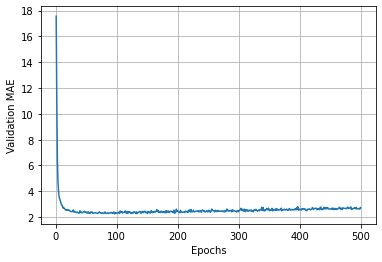

In [13]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k): # k-fold cross validation
    print(f'Processing fold #{i}')
    
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_target = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)* num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)* num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,validation_data=(val_data,val_target), epochs=num_epochs, batch_size=10, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    val_mse, val_mae = model.evaluate(val_data, val_target, verbose=0)
    all_mae_histories.append(mae_history)
    
average_mae_histories = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1,len(average_mae_histories)+1), average_mae_histories)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.grid()
plt.show()
    

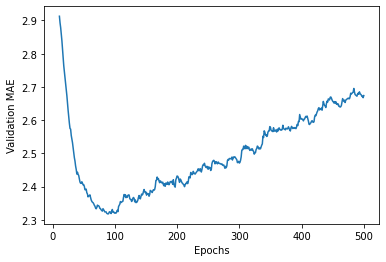

In [19]:
def smooth_curve(points, factor=0.9):
    smoothed_points= []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else: 
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_histories = smooth_curve(average_mae_histories[10:])

plt.plot(range(1+10,len(smooth_mae_histories)+1+10), smooth_mae_histories)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


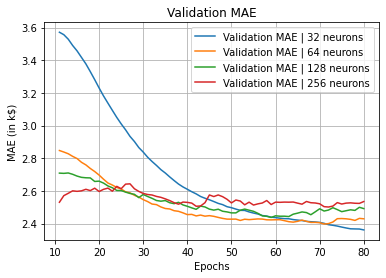

In [24]:
num_epochs = 80
drop_first_epoch = 10
model_list = []
for neurons in [32,64,128,256]:

    average_mae_histories = K_fold(k=4,epochs=num_epochs,neurons=neurons,layer=2)

    smooth_mae_histories = smooth_curve(average_mae_histories[drop_first_epoch:])
    plt.plot(range(1+drop_first_epoch,len(smooth_mae_histories)+1+drop_first_epoch), smooth_mae_histories,label=f'Validation MAE | {neurons} neurons')

plt.grid()
plt.title('Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE (in k$)')
plt.legend()

plt.show()

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


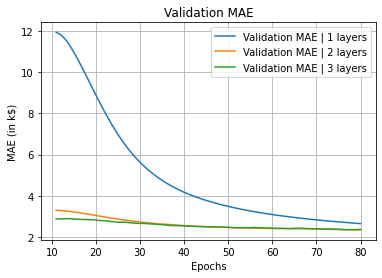

In [26]:
num_epochs = 80
drop_first_epoch = 10
neurons = 64

model_list = []
for l in [1,2,3]:

    average_mae_histories = K_fold(k=4,epochs=num_epochs,neurons=neurons,layer=l)

    smooth_mae_histories = smooth_curve(average_mae_histories[drop_first_epoch:])
    plt.plot(range(1+drop_first_epoch,len(smooth_mae_histories)+1+drop_first_epoch), smooth_mae_histories,label=f'Validation MAE | {l} layers')

plt.grid()
plt.title('Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE (in k$)')
plt.legend()

plt.show()

In [31]:
num_epochs = 80
neurons = 64
l = 2

model = build_model(neurons=neurons,layer=l)
model.fit(train_data,train_targets,
          epochs=num_epochs,batch_size=8,verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(f"Final score (in k$): {test_mae_score}")

4/4 [==============================] - 0s 4ms/step - loss: 16.4598 - mean_absolute_error: 2.6180
Final score (in k$): 2.618048906326294
